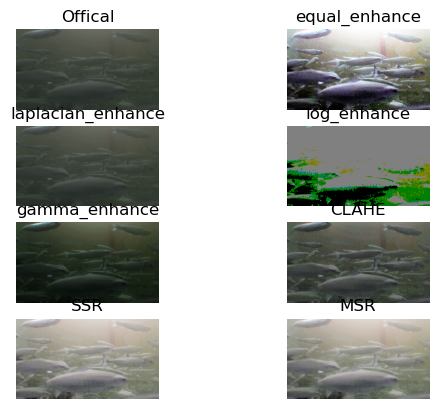

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 直方图均衡增强
def hist(image):
    r, g, b = cv2.split(image)
    r1 = cv2.equalizeHist(r)
    g1 = cv2.equalizeHist(g)
    b1 = cv2.equalizeHist(b)
    image_equal_clo = cv2.merge([r1, g1, b1])
    return image_equal_clo


# 拉普拉斯算子
def laplacian(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image_lap = cv2.filter2D(image, cv2.CV_8UC3, kernel)
  
    return image_lap


# 对数变换
def log(image):
    image_log = np.uint8(np.log(np.array(image) + 1))
    cv2.normalize(image_log, image_log, 0, 255, cv2.NORM_MINMAX)
    # 转换成8bit图像显示
    cv2.convertScaleAbs(image_log, image_log)
    return image_log


# 伽马变换
def gamma(image):
    fgamma = 2
    image_gamma = np.uint8(np.power((np.array(image) / 255.0), fgamma) * 255.0)
    cv2.normalize(image_gamma, image_gamma, 0, 255, cv2.NORM_MINMAX)
    cv2.convertScaleAbs(image_gamma, image_gamma)
    return image_gamma


# 限制对比度自适应直方图均衡化CLAHE
def clahe(image):
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    image_clahe = cv2.merge([b, g, r])
    return image_clahe


def replaceZeroes(data):
    min_nonzero = min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data


# retinex SSR
def SSR(src_img, size):
    L_blur = cv2.GaussianBlur(src_img, (size, size), 0)
    img = replaceZeroes(src_img)
    L_blur = replaceZeroes(L_blur)

    dst_Img = cv2.log(img/255.0)
    dst_Lblur = cv2.log(L_blur/255.0)
    dst_IxL = cv2.multiply(dst_Img, dst_Lblur)
    log_R = cv2.subtract(dst_Img, dst_IxL)

    dst_R = cv2.normalize(log_R,None, 0, 255, cv2.NORM_MINMAX)
    log_uint8 = cv2.convertScaleAbs(dst_R)
    return log_uint8


def SSR_image(image):
    size = 3
    b_gray, g_gray, r_gray = cv2.split(image)
    b_gray = SSR(b_gray, size)
    g_gray = SSR(g_gray, size)
    r_gray = SSR(r_gray, size)
    result = cv2.merge([b_gray, g_gray, r_gray])
    return result


# retinex MMR
def MSR(img, scales):
    weight = 1 / 3.0
    scales_size = len(scales)
    h, w = img.shape[:2]
    log_R = np.zeros((h, w), dtype=np.float32)

    for i in range(scales_size):
        img = replaceZeroes(img)
        L_blur = cv2.GaussianBlur(img, (scales[i], scales[i]), 0)
        L_blur = replaceZeroes(L_blur)
        dst_Img = cv2.log(img/255.0)
        dst_Lblur = cv2.log(L_blur/255.0)
        dst_Ixl = cv2.multiply(dst_Img, dst_Lblur)
        log_R += weight * cv2.subtract(dst_Img, dst_Ixl)

    dst_R = cv2.normalize(log_R,None, 0, 255, cv2.NORM_MINMAX)
    log_uint8 = cv2.convertScaleAbs(dst_R)
    return log_uint8


def MSR_image(image):
    scales = [15, 101, 301]  # [3,5,9]
    b_gray, g_gray, r_gray = cv2.split(image)
    b_gray = MSR(b_gray, scales)
    g_gray = MSR(g_gray, scales)
    r_gray = MSR(r_gray, scales)
    result = cv2.merge([b_gray, g_gray, r_gray])
    return result


if __name__ == "__main__":
    image = cv2.imread('fish.jpg')
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    plt.subplot(4, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Offical')

    # 直方图均衡增强
    image_equal_clo = hist(image)
    cv2.imwrite('fish_equal_clo.jpg',image_equal_clo)
    plt.subplot(4, 2, 2)
    plt.imshow(image_equal_clo)
    plt.axis('off')
    plt.title('equal_enhance')

    # 拉普拉斯算法增强
    image_lap = laplacian(image)
    cv2.imwrite('fish_laplacian.jpg',image_lap)
    plt.subplot(4, 2, 3)
    plt.imshow(image_lap)
    plt.axis('off')
    plt.title('laplacian_enhance')

    # LoG对象算法增强
    image_log = log(image)
    cv2.imwrite('fish_log.jpg',image_log)
    plt.subplot(4, 2, 4)
    plt.imshow(image_log)
    plt.axis('off')
    plt.title('log_enhance')

    # # 伽马变换
    image_gamma = gamma(image)
    cv2.imwrite('fish_gamma.jpg',image_gamma)
    plt.subplot(4, 2, 5)
    plt.imshow(image_gamma)
    plt.axis('off')
    plt.title('gamma_enhance')

    # CLAHE
    image_clahe = clahe(image)
    cv2.imwrite('fish_CLAHE.jpg',image_clahe)
    plt.subplot(4, 2, 6)
    plt.imshow(image_clahe)
    plt.axis('off')
    plt.title('CLAHE')

    # retinex_ssr
    image_ssr = SSR_image(image)
    cv2.imwrite('fish_ssr.jpg',image_ssr)
    plt.subplot(4, 2, 7)
    plt.imshow(image_ssr)
    plt.axis('off')
    plt.title('SSR')

    # retinex_msr
    image_msr = MSR_image(image)
    cv2.imwrite('fish_msr.jpg',image_msr)
    plt.subplot(4, 2, 8)
    plt.imshow(image_msr)
    plt.axis('off')
    plt.title('MSR')

    plt.show()

In [11]:
#USM图像锐化算法
import cv2 as cv
import numpy as np

src = cv.imread("fish.jpg")
#cv.namedWindow("input", cv.WINDOW_AUTOSIZE)
#cv.imshow("input", src)

# sigma = 5、15、25
blur_img = cv.GaussianBlur(src, (0, 0), 5)
usm = cv.addWeighted(src, 1.5, blur_img, -0.5, 0)
cv.imshow("mask image", usm)

h, w = src.shape[:2]
result = np.zeros([h, w*2, 3], dtype=src.dtype)
result[0:h,0:w,:] = src
result[0:h,w:2*w,:] = usm
cv.putText(result, "original image", (10, 30), cv.FONT_ITALIC, 1.0, (0, 0, 255), 2)
cv.putText(result, "sharpen image", (w+10, 30), cv.FONT_ITALIC, 1.0, (0, 0, 255), 2)
cv.imshow("sharpen_image", result)
cv.imwrite("fish_usm.jpg", result)

cv.waitKey(0)
cv.destroyAllWindows()

In [12]:
#图像去噪
import cv2
import numpy as np

# Read the noisy image
img = cv2.imread("fish_ACE.jpg")

# Apply non-local means denoising algorithm
denoise = cv2.fastNlMeansDenoisingColored(img, None, 3, 3, 7, 21)

# Save the denoised image
cv2.imwrite("denoised_fish.jpg", denoise)

True

In [1]:
#灰度世界
import numpy as np
import cv2


def grayworld(img):
    height,width = img.shape[:2]
    dst = np.zeros((height,width,3),dtype=np.float64)
    BGR = np.sum(img,axis=(1,2))
    BGR = np.divide(BGR,height*width)
    GrayValue = np.mean(BGR)
    kb = GrayValue / BGR[0]
    kg = GrayValue / BGR[1]
    kr = GrayValue / BGR[2]

    dst[:,:,0] = np.multiply(kb,img[:,:,0])
    dst[:,:,1] = np.multiply(kg,img[:,:,1])
    dst[:,:,2] = np.multiply(kr,img[:,:,2])
    dst = np.where(dst>255.0,255, dst).astype(np.uint8)
    return dst



if __name__ == '__main__':
    img = cv2.imread("fish.jpg")
    dst = grayworld(img)
    cv2.imshow("raw_img",img)
    cv2.imshow("dst_img",dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [4]:
import numpy as np
import cv2
 
image = cv2.imread('fish.jpg')
b,g,r = cv2.split(image)
b_avg = cv2.mean(b)[0]
g_avg = cv2.mean(g)[0]
r_avg = cv2.mean(r)[0]

avg = (b_avg+g_avg+r_avg)/3
b_k = avg/b_avg
g_k = avg/g_avg
r_k = avg/r_avg
 
b = (b*b_k).clip(0,255)
g = (g*g_k).clip(0,255)
r = (r*r_k).clip(0,255)
 
image = cv2.merge([b,g,r]).astype(np.uint8)

cv2.imshow('gray_world',image)
cv2.waitKey(0)


-1